In [1]:
import pandas as pd
import numpy as np 
import os
import seaborn as sns
import re
from datetime import date,datetime,timedelta

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from scipy import stats 

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from textblob import TextBlob, Word
from sklearn.metrics import mean_squared_error

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict

from sklearn.linear_model import LinearRegression

In [2]:
#Let's import data and get a hang of it
df = pd.read_csv('JEOPARDY_CSV.csv')
print(df.shape)
df.head(2)

(216930, 7)


,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe


### Took only first 10k datapoints to work with Jupyter

In [3]:
df1 = df.copy(deep=True)
df1 = df1[:10000]

In [4]:
# Also on a higher level we don't find any missing values accross columns
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Show Number  10000 non-null  int64 
 1    Air Date    10000 non-null  object
 2    Round       10000 non-null  object
 3    Category    10000 non-null  object
 4    Value       10000 non-null  object
 5    Question    10000 non-null  object
 6    Answer      10000 non-null  object
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


## Just to get the data into a format on which regression models can be implemented, features need to be manipulated.
#### Observations :      
    - Value is output variable.     
    - On each independent feature, feature engineering has to be done.     
    - Date has to be broken to features.     
    - Round and Category has to be converted to feature using one hot encoder.     
    - In Value will impute the None values.     
    - Questions  and Answers being the most important featues have to be converted to features using Statistical NLP techniques.    
    
#### Assumptions :    
    - If Round == 'Final Jeopardy!', then setting the Value as the maximum Value of the Data set.    
    - If Round == 'Tiebreaker', then seting the Value as 0.   
    - Let's assume Show Number has no effect on Value, we'll drop it.

## Value Column -- Target Variable
### Converting the datatype of this column

In [5]:
listy = []
for i in range(len(df1[' Value'])) :
    x = df1[' Value'][i]
    
    if x != 'None' :
        y = x[1:]
        y = y.replace(',','')
        listy.append(int(y))
maxi = max(listy)

In [6]:
for i in range(len(df1[' Value'])) :
    x = df1[' Value'][i]
    z = df1[' Round'][i]
    
    if x == 'None' and z == 'Final Jeopardy!' :
        df1[' Value'][i] = maxi
    
    elif x == 'None' and z == 'Tiebreaker' :
        df1[' Value'][i] = 0
        
    else :
        y = x[1:]
        y = y.replace(',','')
        df1[' Value'][i] = int(y)
        
df1[' Value'] = pd.to_numeric(df1[' Value'])        

<ipython-input-6-db6de7b3e2fd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[' Value'][i] = int(y)
<ipython-input-6-db6de7b3e2fd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[' Value'][i] = maxi


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Show Number  10000 non-null  int64 
 1    Air Date    10000 non-null  object
 2    Round       10000 non-null  object
 3    Category    10000 non-null  object
 4    Value       10000 non-null  int64 
 5    Question    10000 non-null  object
 6    Answer      10000 non-null  object
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [8]:
a = df1[' Value'].unique()
a.sort()
a

array([  100,   200,   300,   367,   400,   500,   600,   700,   800,
         900,  1000,  1100,  1200,  1300,  1400,  1492,  1500,  1600,
        1800,  1900,  2000,  2100,  2127,  2200,  2400,  2500,  2600,
        2800,  3000,  3100,  3200,  3300,  3400,  3600,  3800,  4000,
        4500,  4800,  5000,  5400,  6000,  6200,  6800,  7000,  7200,
        7400,  8000, 10000, 12000], dtype=int64)

In [9]:
print(df1[' Value'].min())
print(df1[' Value'].max())

100
12000


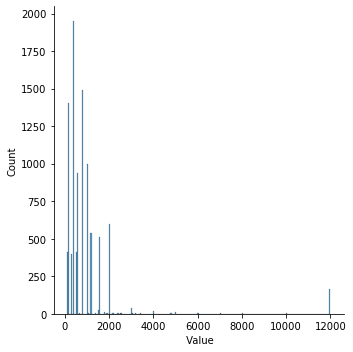

In [10]:
sns.displot(x=df1[' Value'])

In [11]:
#Con verting Value to Z-Score
df1[' Value'] = stats.zscore(df1[' Value'])

#### Here clearly we can see that maximum Questions have Value either <2000 or ~12000
#### Ideal way would be to divide the dataset into parts and then do modelling on it, but I am continuing as is.

## Show Number Column 
#### Dropping this column

In [12]:
df1 = df1.drop('Show Number',axis = 1)

## Air Date Column    
#### Creating more featues from the date and dropping the Date column.   
(Many more features can be created from just the date, let's just use the below as of now).

In [13]:
df1[' Air Date'] = df1[' Air Date'].apply(pd.to_datetime)

In [14]:
#Since the type of this column is object converting it to datetime to be able to work with it
df1[' Air Date'] = df1[' Air Date'].apply(pd.to_datetime)

#Creating below features out of it
df1['Year']=df1[' Air Date'].dt.year 
df1['Month']=df1[' Air Date'].dt.month 
df1['Day']=df1[' Air Date'].dt.day
df1['DayOfWeek_Num']=df1[' Air Date'].dt.dayofweek  
df1['Week_of_Year']=df1[' Air Date'].dt.weekofyear
df1['Quarter'] = df1[' Air Date'].dt.quarter  
df1['Days_in_Month'] = df1[' Air Date'].dt.days_in_month  

#Dropping the original Air Date Column
df1.drop(' Air Date',axis=1,inplace=True)

<ipython-input-14-110d1a9707ac>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df1['Week_of_Year']=df1[' Air Date'].dt.weekofyear


In [15]:
df1.head(2)

,Round,Category,Value,Question,Answer,Year,Month,Day,DayOfWeek_Num,Week_of_Year,Quarter,Days_in_Month
0,Jeopardy!,HISTORY,-0.470393,"For the last 8 years of his life, Galileo was ...",Copernicus,2004,12,31,4,53,4,31
1,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,-0.470393,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004,12,31,4,53,4,31


## Round Column
#### As we can see that Round column's unique values are only 3 :   
- Jeopardy!'   
- 'Double Jeopardy!'   
- 'Final Jeopardy!'    
let's use one-hot encoding for this.


In [16]:
df1[' Round'].unique()

array(['Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!'], dtype=object)

In [17]:
df1 = pd.concat([df1, pd.get_dummies(df1[' Round'], drop_first=True)], axis=1)

In [18]:
df1.drop(' Round', axis = 1, inplace=True)

## Category Column
- Here we have number of unique columns is as high as 1902.
- There are few categories which are just years. I'll be converting them to a Category named 'time_based_questions'.
- Also, to simplify I will remove all special characters from the category name and convert it to lower case
- Finally, Category column will be one-hot-encoded.

In [19]:
df1['Category1'] = ''
df1[' Category'] = df1[' Category'].astype('string')
df1['Category1'] = df1['Category1'].astype('string')

for i in range(len(df1[' Category'])) :
    #print(hah['Name'][i])
    x = re.sub('[^A-Za-z0-9 ]+', '',df1[' Category'][i])
    x = re.sub(' ', '_',x)
    #print(x)
    df1['Category1'][i] = x
    
    if any(c.isalpha() for c in df1['Category1'][i]) == False :
        df1['Category1'][i] = 'time_based_questions'
  
        
df1["Category1"] = df1["Category1"].str.lower()

In [20]:
df1 = pd.concat([df1, pd.get_dummies(df1['Category1'], drop_first=True)], axis=1)
df1.drop(' Category', axis = 1, inplace=True)

In [21]:
df1.shape

(10000, 1891)

## We have 1893 features now

# YAHAN Create Model 1 real quick

## Model 2 : Question Column
- In Pre-processing we are removing stop words, special characters, converting them to lower case

## CountVectorizer Part

In [22]:
# Creating subset of only Questions columns
hah = df1[[' Question']].copy()

In [23]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, "", text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split() if not word in STOPWORDS]) # delete stopwords from text
    return text

In [24]:
for i in range(len(hah[' Question'])):
    hah[' Question'][i] = text_prepare(hah[' Question'][i])

In [25]:
# Need to attach the y (Value) variable to it
hah1 = pd.concat([hah, df1[' Value']], axis=1)
hah1 = hah1.rename(columns={' Question' : 'Ques', ' Value' : 'Val'})

In [26]:
X = hah1.Ques
y = hah1.Val

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7500,)
(2500,)
(7500,)
(2500,)


### Using Count Vectorizer here

In [27]:
vect = CountVectorizer(ngram_range=(1, 1), max_features = 5000) # 1 gram being used, 3,4 gram models can also be made
vect.fit(X_train) # Features are getting created here
X_train_dtm = vect.transform(X_train) # Here the DTM is created 
X_test_dtm = vect.transform(X_test) # Creating DTM for X_test also

### Just to get a hang of the DTM created

In [28]:
col_names = vect.get_feature_names() # We can see the feature names here
X_train_dtm_array = X_train_dtm.toarray() # We can convert the Sparse matrix to Array
dtm_df = pd.DataFrame(X_train_dtm_array,columns = col_names) #DTM df is created
dtm_df.head(2)

,000,10,100,1000,100th,11,117,11th,12,125,...,younger,youngest,youre,youth,youve,zealand,zeus,zion,zodiac,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Applying Linear regression to the above Matrix

In [29]:
# import and instantiate a logistic regression model
linreg = LinearRegression()
# train the model using X_train_dtm
linreg.fit(X_train_dtm, y_train)
# make class predictions for X_test_dtm
y_pred = linreg.predict(X_test_dtm)

# Yahan Accuracy bhi dal do real quick
# RMSE for the above dataset

In [30]:
mean_squared_error(y_test, y_pred)

2.802139921680341

## Tf-idf Part
After some analysis I found that some more stop words needs to be added to the corpus to get better and reduce the features, like :
- Removing URLS here
- Removal of All numbers
- Lemamtization post POS Tagging

In [50]:
# Again creating subset of only Questions columns (Let's start again to remove stuffs)
hah = df1[[' Question']].copy()

In [51]:
# Function to remove all the URLS
def remove_urls(x) : 
    start = x.find("<a href=")
    end = x.find(">")
    if start != -1 and end != -1:
        result = x[start+1:end]
        x = x.replace(result, '')
    return x

In [52]:
for i in range(len(hah[' Question'])):
    hah[' Question'][i] = remove_urls(hah[' Question'][i])

In [53]:
REPLACE_BY_SPACE_RE = re.compile('[_/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^a-z #+_]') #Removed numbers also this time, as I found it doesn't have much importance to the context in Questions

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, "", text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = " ".join([word for word in text.split() if not word in stopwords]) # delete stopwords from text
    text = " ".join([word for word in text.split() if not word in STOPWORDS]) # delete stopwords from text
    return text

In [54]:
# Need to attach the y (Value) variable to it
hah1 = pd.concat([hah, df1[' Value']], axis=1)
hah1 = hah1.rename(columns={' Question' : 'Ques', ' Value' : 'Val'})

# Lemmatization post POS tagging

In [55]:
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [57]:
for i in range(len(hah1['Ques'])) :
    x = hah1['Ques'][i]
    #print(x)
    tokens = word_tokenize(x)
    lemma_function = WordNetLemmatizer()
    
    listy =[]
    for token, tag in pos_tag(tokens):
        lemma = lemma_function.lemmatize(token, tag_map[tag[0]])
        #print(token, "=>", lemma)
        listy.append(lemma)
    #print(listy)
    str1 = ' '.join(listy)
    #print(str1)
    hah1['Ques'][i] = str1
    #if i == 1 :
        #break

<ipython-input-57-b31a511173c8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hah1['Ques'][i] = str1


In [58]:
hah1['Ques'].head(2)

0    For the last 8 year of his life , Galileo be u...
1    No . 2 : 1912 Olympian ; football star at Carl...
Name: Ques, dtype: object

In [59]:
X = hah1.Ques
y = hah1.Val

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7500,)
(2500,)
(7500,)
(2500,)


In [60]:
vect = TfidfVectorizer(max_features = 5000, ngram_range = (1,3)) #Considering only top 5000 features and 1,2 & 3 gram 
X_train_DTM = pd.DataFrame(vect.fit_transform(X_train).toarray(), columns=vect.get_feature_names())

In [73]:
X_test_DTM = pd.DataFrame(vect.fit_transform(X_test).toarray(), columns=vect.get_feature_names())

In [61]:
X_train_DTM.head(2)

,000,000 year,01,02,03,04,05,06,07,10,...,you ve,you ve be,you wo,young,young man,your,yourself,youth,zealand,zodiac
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# import and instantiate a logistic regression model
linreg = LinearRegression()
# train the model using X_train_dtm
linreg.fit(X_train_DTM, y_train)


LinearRegression()

In [80]:
# make class predictions for X_test_dtm
y_pred = linreg.predict(X_test_DTM)

In [81]:
y_test.shape

(2500,)

In [82]:
mean_squared_error(y_test, y_pred)

1.4856615544568415e+27

# Word Cloud

In [77]:
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization 
from wordcloud import WordCloud, STOPWORDS # this module is for making wordcloud in python

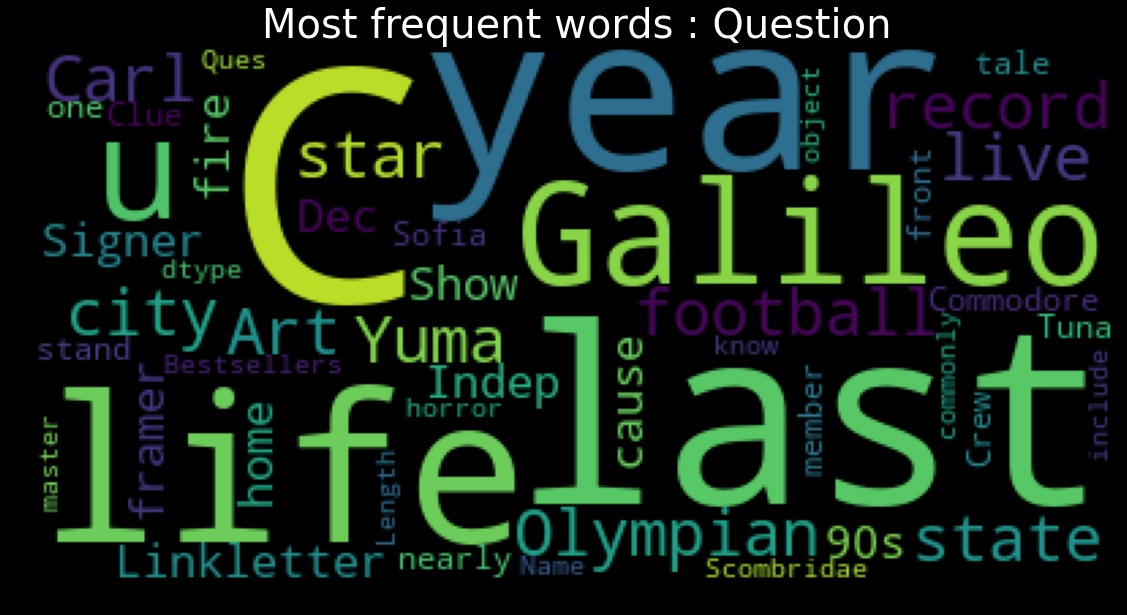

In [78]:
# define wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud()
# generate word cloud using df_yelp_tip_top['text_clear']
wc.generate(str(hah1['Ques']))
# declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# add title to the graph
plt.title("Most frequent words : Question", fontsize=40,color='white')
plt.imshow(wc)
plt.show()

In [ ]:
# Number of rows display code
pd.options.display.max_rows = 9


In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
# String length display code
pd.options.display.max_colwidth

## Answer column

## Answer to storage thing

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros** (typically more than 99% of them).

> For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

> In order to be able to **store such a matrix in memory** but also to **speed up operations**, implementations will typically use a **sparse representation** such as the implementations available in the `scipy.sparse` package.